In [1]:
%%capture
!pip install nussl
!pip install tensorflow
import numpy as np
import librosa
import tensorflow as tf
import IPython.display as ipd
import IPython
import librosa.display
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.optimizers import SGD
import matplotlib.pyplot as plt
import torch
from torch import nn
import nussl

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
musdb = nussl.datasets.MUSDB18(download=True)

Done!


In [4]:
mixture, drum, bass, rest, vocal = 0, 1, 2, 3, 4
hop_length = 768
window_length = 1024
srate = 44100
frame_size = 128
slice_hopsize = 8#np.int(128/8)
train_size = np.int(len(musdb)*0.7)

In [5]:
def min_max_norm(data):
  min, max = np.min(data), np.max(data)
  return (data-min)/(max-min)

In [6]:
def get_softmask(item):
  representation = np.abs(item['mix'].stft(hop_length=hop_length, window_length=window_length,window_type='hann' ))
  vocals_representation = np.abs(item['sources']['vocals'].stft(hop_length=hop_length, window_length=window_length, 
                                  window_type='hann' ))
  mask = vocals_representation / (np.maximum(vocals_representation, representation) + 1e-8)
  
  return mask

In [7]:
def get_binarymask(item):
  mask = get_softmask(item)

  mask[mask>0.5]=1
  mask[mask<=0.5] = 0
  return mask

In [8]:
def slice(spec, mask, frame_size):

  left_spec = spec[...,0][0:512,:]
  right_spec = spec[...,1][0:512,:]

  left_mask = mask[...,0][0:512,:]
  right_mask = mask[...,1][0:512,:]

  X = []
  y = []
  length = spec.shape[1]
  for i in range(0, length-frame_size, slice_hopsize):
    X.append(left_spec[...,i:i+frame_size])
    X.append(right_spec[...,i:i+frame_size])

  for i in range(0, length-frame_size, slice_hopsize):
    y.append(left_mask[..., i:i+frame_size])
    y.append(right_mask[..., i:i+frame_size])
  
  X = np.array(np.stack(X))
  y = np.array(np.stack(y))

  return X, y

In [9]:
def get_dataset():
  X_train = []
  y_train = []
  
  for i in range(train_size):
    print(i, end=' ')
    if i%30 == 29:
      print()

    track = musdb[i]
    mixture_spec = np.abs(track['mix'].stft(hop_length=hop_length, 
                          window_length=window_length,window_type='hann' ))

    mixture_spec_db = librosa.amplitude_to_db(mixture_spec)

    mask = get_binarymask(track)

    X, y = slice(mixture_spec_db, mask, frame_size)
    X_train.extend(X)
    y_train.extend(y)

  X_train = np.array(np.stack(X_train)).reshape(-1, 512, 128, 1)
  y_train = np.array(np.stack(y_train))

  return X_train, y_train

In [10]:
X_train, y_train = get_dataset()
print()
print(X_train.shape)
print(y_train.shape)

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 
30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 
60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 
90 91 92 93 94 95 96 97 98 99 
(6600, 512, 128, 1)
(6600, 512, 128)


In [11]:
X_train = min_max_norm(X_train)
print(X_train.shape)
print(np.min(X_train), np.max(X_train))

(6600, 512, 128, 1)
0.0 1.0


In [12]:
def UNet():
    inputs = layers.Input((512, 128, 1))
    
    conv1 = layers.Conv2D(16, (5,5), padding='same', 
                      strides=2, activation=layers.LeakyReLU(0.2), name='conv1')(inputs)
    batch1 = layers.BatchNormalization(axis=-1)(conv1)
    conv2 = layers.Conv2D(32, (5,5), padding='same', 
                      strides=2, activation=layers.LeakyReLU(0.2), name='conv2')(batch1)
    batch2 = layers.BatchNormalization(axis=-1)(conv2)
    conv3 = layers.Conv2D(64, (5,5), padding='same', 
                      strides=2, activation=layers.LeakyReLU(0.2), name='conv3')(batch2)
    batch3 = layers.BatchNormalization(axis=-1)(conv3)
    conv4 = layers.Conv2D(128, (5,5), padding='same', 
                      strides=2, activation=layers.LeakyReLU(0.2), name='conv4')(batch3)
    batch4 = layers.BatchNormalization(axis=-1)(conv4)
    conv5 = layers.Conv2D(256, (5,5), padding='same', 
                      strides=2, activation=layers.LeakyReLU(0.2), name='conv5')(batch4)
    batch5 = layers.BatchNormalization(axis=-1)(conv5)
    bottleneck = layers.Conv2D(512, (5,5), padding='same', 
                      strides=2, activation=layers.LeakyReLU(0.2), name='bottleneck')(batch5)
    deconv5 = layers.Conv2DTranspose(256, (5,5), padding='same', 
                      strides=2, activation='relu', name='deconv5')(bottleneck)
    drop1 = layers.Dropout(0.5)(deconv5)
    concat5 = layers.concatenate([drop1, conv5], axis=-1)
    batch6 = layers.BatchNormalization(axis=-1)(concat5)
    
    deconv4 = layers.Conv2DTranspose(128, (5,5), padding='same', 
                      strides=2, activation='relu', name='deconv4')(batch6)
    
    drop2 = layers.Dropout(0.5)(deconv4)
    concat4 = layers.concatenate([drop2, conv4], axis=-1)
    batch7 = layers.BatchNormalization(axis=-1)(concat4)
    deconv3 = layers.Conv2DTranspose(64, (5,5), padding='same', 
                      strides=2, activation='relu', name='deconv3')(batch7)
    
    drop3 = layers.Dropout(0.5)(deconv3)
    concat3 = layers.concatenate([drop3, conv3], axis=-1)
    batch8 = layers.BatchNormalization(axis=-1)(concat3)
    deconv2 = layers.Conv2DTranspose(32, (5,5), padding='same', 
                      strides=2, activation='relu', name='deconv2')(batch8)

    concat2 = layers.concatenate([deconv2, conv2], axis=-1)
    batch9 = layers.BatchNormalization(axis=-1)(concat2)

    deconv1 = layers.Conv2DTranspose(16, (5,5), padding='same', 
                      strides=2, activation='relu', name='deconv1')(batch9)

    batch10 = layers.BatchNormalization(axis=-1)(deconv1)
    concat1 = layers.concatenate([deconv1, conv1], axis=-1)

    batch11 = layers.BatchNormalization(axis=-1)(concat1)
    outputs = layers.Conv2DTranspose(1, (5, 5), strides=2, padding="same", 
                      activation="sigmoid", name='output')(batch11)
    model = models.Model(inputs, outputs)
    print(model.summary())
    return model
unet = UNet()
unet.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss='BinaryCrossentropy',
                 metrics=[tf.keras.metrics.BinaryAccuracy(threshold=0.5)])

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 512, 128, 1) 0                                            
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 256, 64, 16)  416         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 256, 64, 16)  64          conv1[0][0]                      
__________________________________________________________________________________________________
conv2 (Conv2D)                  (None, 128, 32, 32)  12832       batch_normalization[0][0]        
______________________________________________________________________________________________

In [13]:
history = unet.fit(X_train, y_train, validation_split=0.33, epochs=100)
unet.save('/content/drive/My Drive/Umodels/'+'final')

Epoch 1/100
139/139 [==============================] - 25s 54ms/step - loss: 0.6376 - binary_accuracy: 0.6382 - val_loss: 0.7761 - val_binary_accuracy: 0.4928
Epoch 2/100
139/139 [==============================] - 6s 46ms/step - loss: 0.5877 - binary_accuracy: 0.6959 - val_loss: 1.1351 - val_binary_accuracy: 0.4930
Epoch 3/100
139/139 [==============================] - 6s 46ms/step - loss: 0.5542 - binary_accuracy: 0.7218 - val_loss: 0.6642 - val_binary_accuracy: 0.6326
Epoch 4/100
139/139 [==============================] - 6s 46ms/step - loss: 0.5287 - binary_accuracy: 0.7403 - val_loss: 0.6642 - val_binary_accuracy: 0.6460
Epoch 5/100
139/139 [==============================] - 6s 46ms/step - loss: 0.5083 - binary_accuracy: 0.7550 - val_loss: 0.6373 - val_binary_accuracy: 0.6663
Epoch 6/100
139/139 [==============================] - 6s 46ms/step - loss: 0.4873 - binary_accuracy: 0.7691 - val_loss: 0.6620 - val_binary_accuracy: 0.6740
Epoch 7/100
139/139 [==============================

INFO:tensorflow:Assets written to: /content/drive/My Drive/Umodels/final/assets


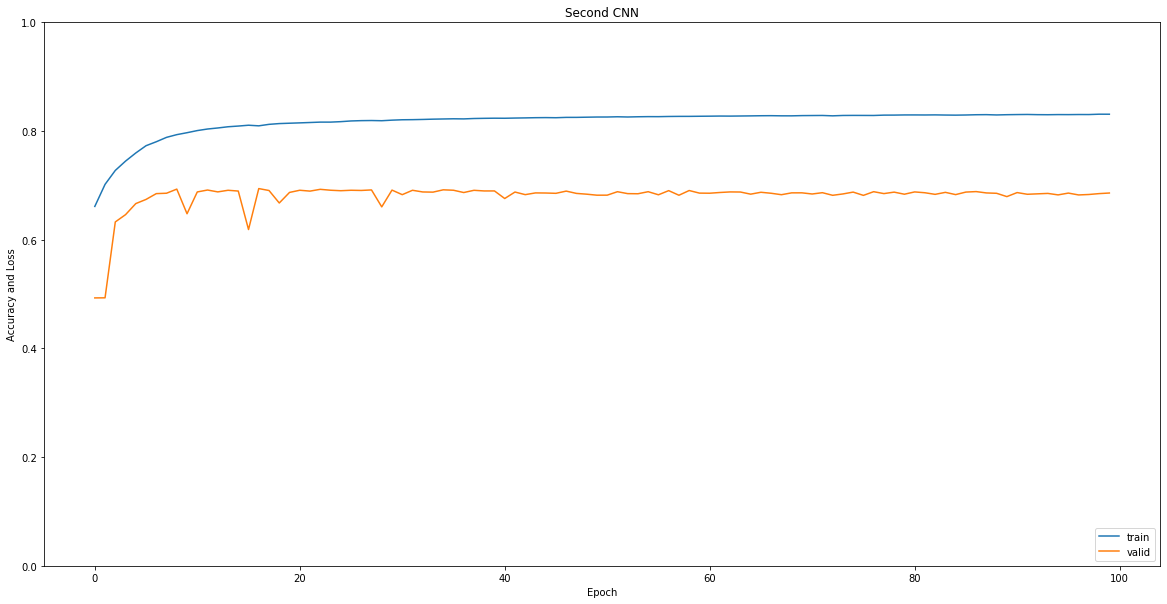

In [14]:
plt.figure(figsize=(20, 10))
plt.plot(history.history['binary_accuracy'][0:100], label='accuracy')
plt.plot(history.history['val_binary_accuracy'][0:100], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy and Loss')
plt.ylim([0.0, 1.0])
plt.title("Second CNN")
plt.legend(['train', 'valid'], loc='lower right')